# 04. 이상 응시자 탐지 및 시각화

## 목적
- `정제된 점수`, `정제된 나이`, `성별`, `시험일`, `재응시여부` 등을 기반으로
- 사전에 정의도니 **6가지 조건**을 모두 평가하고,
- 이상 응시자들 태깅하여 별도로 저장하고, 시각화한다,

## 주요 작업
- 이상 조건별 Boolean 컬럼 생성
- 이상조건 충족 수 계산 및 `is_suspicious` 태깅
- 이상 응시자 통계 분석 및 시각화
- 이상 응시자 로그 출력 및 저장

### 1. 라이브러리 및 스크립트 로딩

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../src')

from apply_cleaning import apply_cleaning
from detect_suspicious import detect_suspicious

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 2. 데이터 로딩 및 정제

In [2]:
RAW_PATH = Path('../raw/messy_student_scores_500.csv')
SAVE_PATH = Path('../data/processed/suspicious_tagged_scores.csv')

# 원본 데이터 로딩
df_raw = pd.read_csv(RAW_PATH)

# 점수/나이 정제 + 재응시여부 추론
df_cleaned = apply_cleaning(df_raw)

# 이상 응시자 태깅
df_tagged = detect_suspicious(df_cleaned)

# 저장
df_tagged.to_csv(SAVE_PATH, index=False)
print(f"[INFO] 이상 응시자 태깅 완료: {SAVE_PATH}")


[INFO] 이상 응시자 태깅 완료: ..\data\processed\suspicious_tagged_scores.csv


c:\Users\sbeep\Desktop\DataAnalysis\MIni_Projects\Messy_Score_Lab\notebooks\../src\detect_suspicious.py:23: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['is_date_missing'] = pd.to_datetime(df['시험일'], errors='coerce').isna()
c:\Users\sbeep\Desktop\DataAnalysis\MIni_Projects\Messy_Score_Lab\notebooks\../src\detect_suspicious.py:35: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['정제된_점수'].isna() | pd.to_datetime(df['시험일'], errors='coerce').isna()


### 3. 이상 응시자 통계 요약

In [3]:
# 전체 응시자 수, 이상 응시자 수
total = len(df_tagged)
suspicious_count = (df_tagged['is_suspicious'] == 'Y').sum()

print(f"전체 응시자 수: {total}")
print(f"이상 응시자 수: {suspicious_count} ({suspicious_count / total:.2%})")

# 평균 점수/나이 비교
print("\n평균 점수/나이:")
print(df_tagged.groupby('is_suspicious')[['정제된_점수', '정제된_나이']].mean())


전체 응시자 수: 500
이상 응시자 수: 464 (92.80%)

평균 점수/나이:
                  정제된_점수     정제된_나이
is_suspicious                      
N              78.939394  20.375000
Y              74.053691  19.093878


### 4. 시각화 - 이상 응시자 비율 파이차트

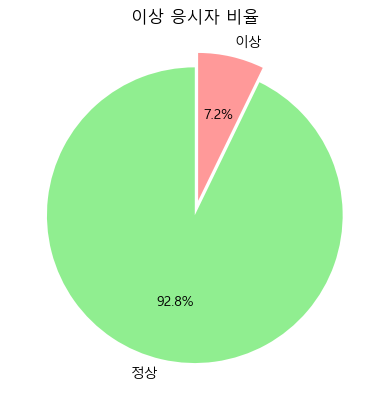

In [4]:
# 파이차트
df_tagged['is_suspicious'].value_counts().plot.pie(
    labels=['정상', '이상'], autopct='%1.1f%%', startangle=90,
    colors=['#90ee90', '#ff9999'], explode=[0, 0.1]
)
plt.title('이상 응시자 비율')
plt.ylabel('')
plt.show()

### 5. 시각화 - 점수 기준 박스플롯

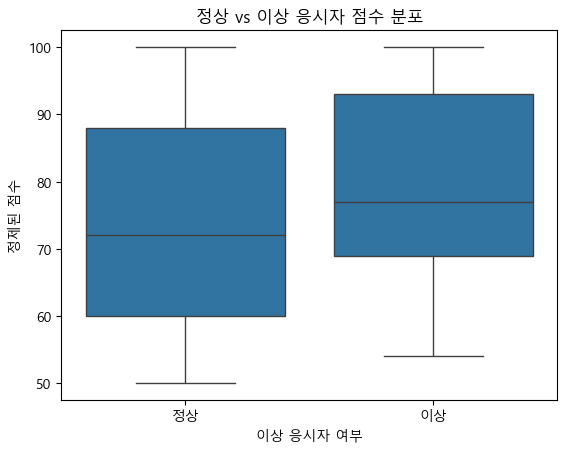

In [5]:
sns.boxplot(x='is_suspicious', y='정제된_점수', data=df_tagged)
plt.title('정상 vs 이상 응시자 점수 분포')
plt.xlabel('이상 응시자 여부')
plt.ylabel('정제된 점수')
plt.xticks([0, 1], ['정상', '이상'])
plt.show()

### 6. 시각화 - 조건별 충족 빈도 막대차트

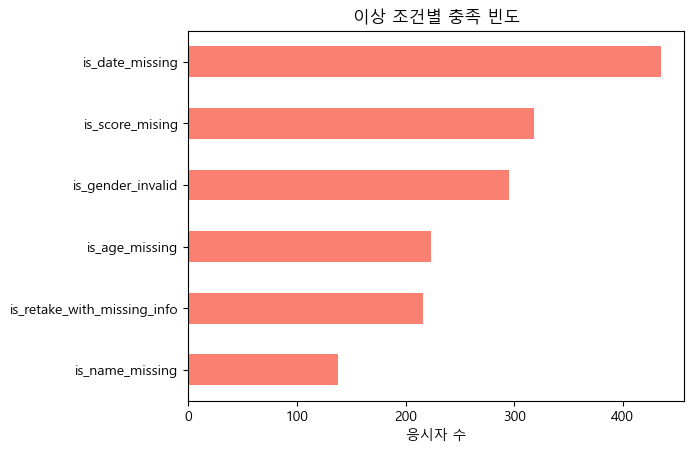

In [6]:
condition_cols = [col for col in df_tagged.columns if col.startswith('is_') and col != 'is_suspicious']
condition_counts = df_tagged[condition_cols].sum().sort_values()

condition_counts.plot(kind='barh', color='salmon')
plt.title('이상 조건별 충족 빈도')
plt.xlabel('응시자 수')
plt.show()


### 7. 이상 응시자 상세 로그 출력

In [8]:
df_suspicious = df_tagged[df_tagged['is_suspicious'] == 'Y']

# 주요 컬럼만 표시
display_cols = ['이름', '나이', '성별', '점수', '시험일', '재응시여부', '정제된_점수', '정제된_나이', 
                '이상조건_충족수', 'is_suspicious'] + condition_cols

df_suspicious[display_cols].head(10)

,이름,나이,성별,점수,시험일,재응시여부,정제된_점수,정제된_나이,이상조건_충족수,is_suspicious,is_name_missing,is_score_mising,is_date_missing,is_age_missing,is_gender_invalid,is_retake_with_missing_info
0,NaN,0x1d,남,NaN,19.09.1979,N,NaN,29.0,3,Y,True,True,False,False,True,False
1,서정남,twenty,male,59점,NaN,N,59.0,20.0,2,Y,False,False,True,False,True,False
2,김영자,NaN,male,ninety-five,NaN,N,NaN,NaN,4,Y,False,True,True,True,True,False
3,NaN,10세,male,none,10-06-1980,Y,NaN,10.0,5,Y,True,True,True,False,True,True
4,김재호,NaN,m,90점,1979년 05월 16일,N,90.0,NaN,2,Y,False,False,True,True,False,False
5,김은서,14,남,ninety-five,NaN,Y,NaN,14.0,4,Y,False,True,True,False,True,True
6,김지원,NaN,F,none,Aug/30/1982,Y,NaN,NaN,4,Y,False,True,True,True,False,True
7,이민지,NaN,남,57,Oct/25/1987,Y,57.0,NaN,4,Y,False,False,True,True,True,True
8,NaN,twenty,f,eighty,1989년 06월 08일,Y,NaN,20.0,4,Y,True,True,True,False,False,True
9,홍예준,twenty,male,eighty,NaN,N,NaN,20.0,3,Y,False,True,True,False,True,False
